# 1. Introduction

In this notebook, we'll conduct a time-series analysis of natural gas consumption.

This project aims to help municipalities and energy companies plan for energy source needs. This project evaluates two main questions: 

1. What are the main factors that drive natural gas consumption?
2. Can the amount of natural gas consumed be predicted and effectively forecasted?

In [566]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics
import matplotlib.pyplot as plt
import json
from urllib.error import URLError, HTTPError
from urllib.request import urlopen
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 2. Get Data

The first step is to create an API call that can work for various types of energy data from the EIA by swapping out the key

In [567]:
class EIAgov(object):
    def __init__(self, token, series):

        self.token = token
        self.series = series

    def Raw(self, ser):
        # Construct url
        url = 'http://api.eia.gov/series/?api_key=' + self.token + '&series_id=' + ser.upper()

        try:
            # URL request, URL opener, read content
            response = urlopen(url);
            raw_byte = response.read()
            raw_string = str(raw_byte, 'utf-8-sig')
            jso = json.loads(raw_string)
            return jso

        except HTTPError as e:
            print('HTTP error type.')
            print('Error code: ', e.code)

        except URLError as e:
            print('URL type error.')
            print('Reason: ', e.reason)

    def GetData(self):
        # Deal with the date series                       
        date_ = self.Raw(self.series[0])
        date_series = date_['series'][0]['data']
        endi = len(date_series) # or len(date_['series'][0]['data'])
        date = []
        for i in range (endi):
            date.append(date_series[i][0])

        # Create dataframe
        df = pd.DataFrame(data=date)
        df.columns = ['Date']

        # Deal with data
        lenj = len(self.series)
        for j in range (lenj):
            data_ = self.Raw(self.series[j])
            data_series = data_['series'][0]['data']
            data = []
            endk = len(date_series)         
            for k in range (endk):
                data.append(data_series[k][1])
            df[self.series[j]] = data
        
        return df



In [568]:
tok = '3a53eeae634d00b544b792189a689b49'
#download natural gas total consumption monthly data
key1 = ['NG.N9140US2.M']
ng = EIAgov(tok, key1)
ng_df = ng.GetData()

#download natural gas Industrial price data
key2 = ['NG.N3035US3.M']
ng_price = EIAgov(tok, key2)
ng_price = ng_price.GetData()

#download natural gas production data
key3 = ['NG.N9070US2.M']
ng_prod = EIAgov(tok, key3)
ng_prod = ng_prod.GetData()

In [569]:
#merge the dataframes
df = ng_df.merge(ng_prod, on='Date', how='inner').merge(ng_price, on='Date', how='inner')
df.head()

,Date,NG.N9140US2.M,NG.N9070US2.M,NG.N3035US3.M
0,201905,2106106,2785972,3.65
1,201904,2182752,2712573,4.02
2,201903,2883397,2791525,4.33
3,201902,2980360,2506257,4.65
4,201901,3380597,2750413,5.04


# 3. Clean Data

In [570]:
#check for null values
df.isnull().values.any()

False

In [571]:
#rename columns
df.columns = ("Date", "Cons_Mcf", "Prod_Mcf", "Price")
df.head()

,Date,Cons_Mcf,Prod_Mcf,Price
0,201905,2106106,2785972,3.65
1,201904,2182752,2712573,4.02
2,201903,2883397,2791525,4.33
3,201902,2980360,2506257,4.65
4,201901,3380597,2750413,5.04


In [572]:
df['Date'].min(), df['Date'].max()

('200101', '201905')

In [573]:
#check data types
df.dtypes

Date         object
Cons_Mcf      int64
Prod_Mcf      int64
Price       float64
dtype: object

In [574]:
#convert date to datetime stamp
df.Date = df.apply(lambda x: datetime.strptime(x['Date'], '%Y%m'), axis=1)
df.dtypes

Date        datetime64[ns]
Cons_Mcf             int64
Prod_Mcf             int64
Price              float64
dtype: object

In [575]:
df.Cons_Mcf = df.Cons_Mcf.astype(float)
df.Prod_Mcf = df.Prod_Mcf.astype(float)

In [576]:
df.dtypes

Date        datetime64[ns]
Cons_Mcf           float64
Prod_Mcf           float64
Price              float64
dtype: object

# 4. Exploratory Analysis

In [577]:
# Evaluate number of data points
print('# data points:', len(df))

# data points: 221


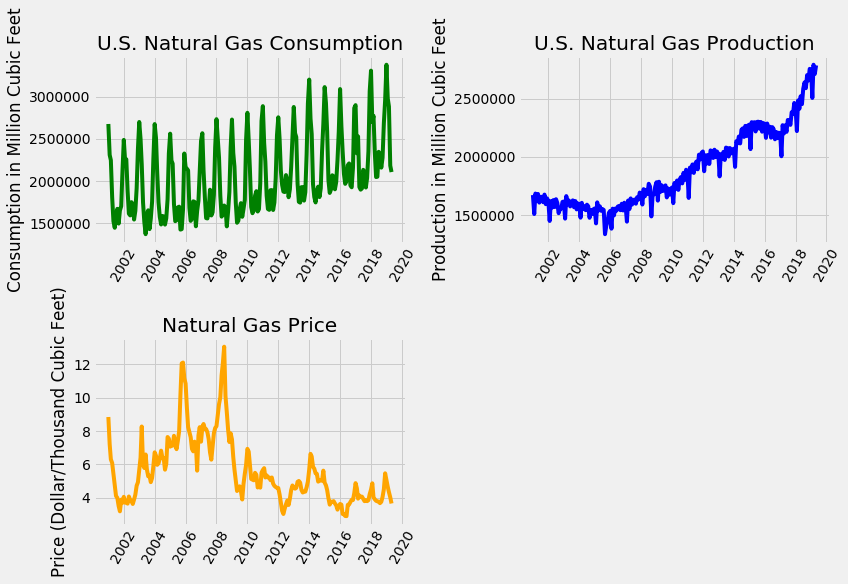

In [578]:
plt.figure(figsize=(12,8))

plt.subplot(221)
plt.plot(df.Date, df.Cons_Mcf, color='green')
plt.ylabel('Consumption in Million Cubic Feet')
plt.title('U.S. Natural Gas Consumption')
plt.xticks(rotation=60)

plt.subplot(222)
plt.plot(df.Date, df.Prod_Mcf, color='blue')
plt.ylabel('Production in Million Cubic Feet')
plt.title('U.S. Natural Gas Production')
plt.xticks(rotation=60)

plt.subplot(223)
plt.plot(df.Date, df.Price, color='orange')
plt.ylabel('Price (Dollar/Thousand Cubic Feet)')
plt.title('Natural Gas Price')
plt.xticks(rotation=60)


plt.tight_layout()
plt.show()

The charts above show an increasing trend in total natural gas consumption and production. Natural gas prices were increasing until 2008 with a couple of major spikes, and then dropped in 2008, likely due to the financial crisis. Additionally, natural gas consumption shows a great deal of seasonality. Now let's look at how consumption, production, and price all relate to one another.

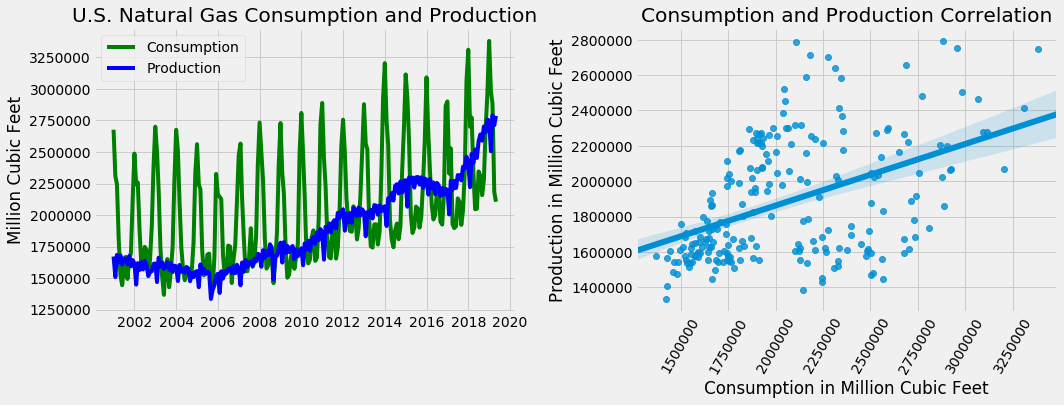


Consumption/Production Regression: LinregressResult(slope=0.3486070344968261, intercept=1165018.7525826236, rvalue=0.4558657030692043, pvalue=9.700450537819767e-13, stderr=0.04599290882383732)


In [579]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(df.Date, df.Cons_Mcf, label='Consumption', color='green')
plt.plot(df.Date, df.Prod_Mcf, label='Production', color='blue')
plt.title('U.S. Natural Gas Consumption and Production')
plt.ylabel('Million Cubic Feet')
plt.legend()

plt.subplot(222)
sns.regplot(df.Cons_Mcf, df.Prod_Mcf)
plt.title('Consumption and Production Correlation')
plt.xlabel('Consumption in Million Cubic Feet')
plt.ylabel('Production in Million Cubic Feet')
plt.xticks(rotation=60)



plt.tight_layout()
plt.show()

print('\nConsumption/Production Regression:', stats.linregress(df.Cons_Mcf, df.Prod_Mcf))

The linear regression above shows that production and consumption are significantly positively correlated.

In [580]:
# Scale to unit prices for better visual comparison since
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

Cons_Mcf = df.Cons_Mcf
Cons_Mcf = Cons_Mcf.values.reshape((len(Cons_Mcf), 1))
Cons_Mcf_norm = scaler.fit_transform(Cons_Mcf)

Prod_Mcf = df.Prod_Mcf
Prod_Mcf = Prod_Mcf.values.reshape((len(Prod_Mcf), 1))
Prod_Mcf_norm = scaler.fit_transform(Prod_Mcf)

Price = df.Price
Price = Price.values.reshape((len(Price), 1))
Price_norm = scaler.fit_transform(Price)

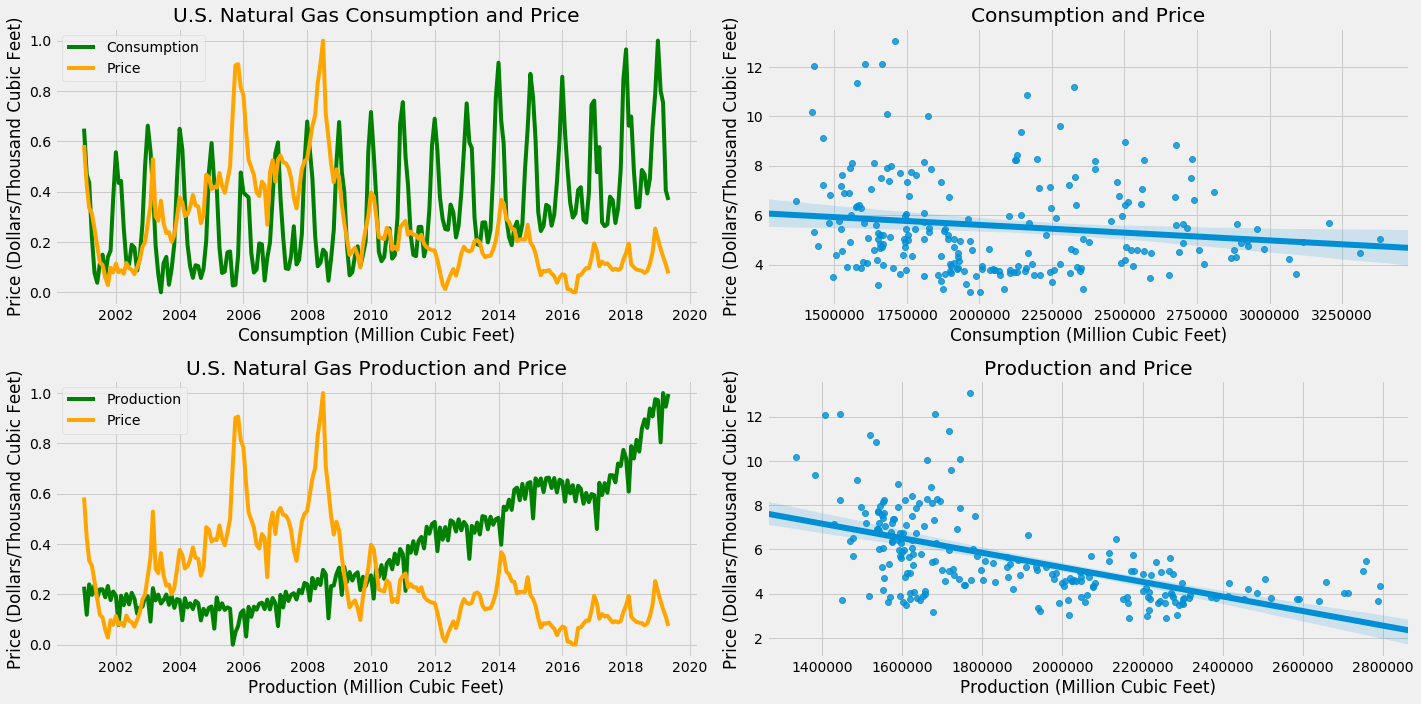


Consumption/Price Regression: LinregressResult(slope=-6.279342059406712e-07, intercept=6.866359709732595, rvalue=-0.14060378406772056, pvalue=0.0367293699085076, stderr=2.9878527990045745e-07)

Productrion/Price Regression: LinregressResult(slope=-3.293303085783775e-06, intercept=11.774192302022936, rvalue=-0.5639151933246191, pvalue=5.960127638992668e-20, stderr=3.2590267510993655e-07)


In [581]:
# Market correlations

plt.figure(figsize=(20,10))

plt.subplot(221)
plt.plot(df.Date, Cons_Mcf_norm, label='Consumption', color='green')
plt.plot(df.Date, Price_norm, label='Price', color='orange')
plt.title('U.S. Natural Gas Consumption and Price')
plt.ylabel('Price (Dollars/Thousand Cubic Feet)')
plt.xlabel('Consumption (Million Cubic Feet)')
plt.legend()

plt.subplot(222)
sns.regplot(df.Cons_Mcf, df.Price)
plt.title('Consumption and Price')
plt.ylabel('Price (Dollars/Thousand Cubic Feet)')
plt.xlabel('Consumption (Million Cubic Feet)')

plt.subplot(223)
plt.plot(df.Date, Prod_Mcf_norm, label='Production', color='green')
plt.plot(df.Date, Price_norm, label='Price', color='orange')
plt.title('U.S. Natural Gas Production and Price')
plt.ylabel('Price (Dollars/Thousand Cubic Feet)')
plt.xlabel('Production (Million Cubic Feet)')
plt.legend()

plt.subplot(224)
sns.regplot(df.Prod_Mcf, df.Price)
plt.title('Production and Price')
plt.ylabel('Price (Dollars/Thousand Cubic Feet)')
plt.xlabel('Production (Million Cubic Feet)')

plt.tight_layout()
plt.show()

print('\nConsumption/Price Regression:', stats.linregress(df.Cons_Mcf, df.Price))
print('\nProductrion/Price Regression:', stats.linregress(df.Prod_Mcf, df.Price))

The linear regression above shows that both consumption of natural gas and production of natural gas are negatively correlated with price, meaning that as the price for natural gas goes down, production and consumption increase. Production has a more linear relationship with price than consumption does, meaning it is affected more severly by changes in price than consumption is.

Monthly Consumption Decomposition


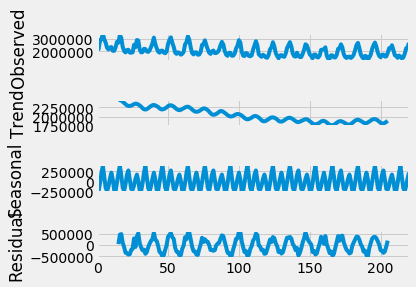

<Figure size 1080x720 with 0 Axes>

In [582]:
from statsmodels.tsa.seasonal import seasonal_decompose
# RUN Monthly
print('Monthly Consumption Decomposition')
decompose = seasonal_decompose(df.Cons_Mcf, model='additive', freq=(30)) # 30 days/month
decompose.plot()
plt.figure(figsize=(15,10))
plt.show()

The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. The above decomposition a negative trend, seasonality, and high variability with consumption data

# 5. Model Prep

Create a energy consumption prediction model

Time series model data needs to be stationary, meaning it is not time dependent. To test if our data is stationary, we are going to use an ADF test. For this test, if the p-value <0.05 we reject the null hypothesis that the data is non-stationary

In [583]:
df = df.set_index(['Date'])

In [584]:
df.head()

,Cons_Mcf,Prod_Mcf,Price
Date,,,
2019-05-01,2106106.0,2785972.0,3.65
2019-04-01,2182752.0,2712573.0,4.02
2019-03-01,2883397.0,2791525.0,4.33
2019-02-01,2980360.0,2506257.0,4.65
2019-01-01,3380597.0,2750413.0,5.04


In [585]:
#determine rolling statistics
rolmean = df['Cons_Mcf'].rolling(window=12).mean()
rolstd= df['Cons_Mcf'].rolling(window=12).std()

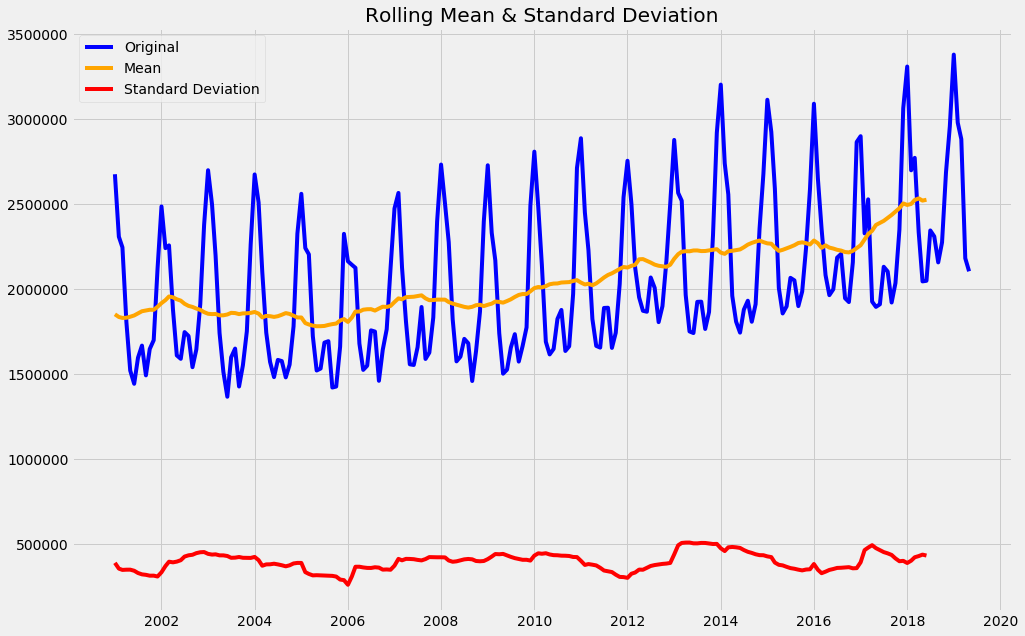

In [586]:
#plot rolling statistics
plt.figure(figsize=(15,10))
org = plt.plot(df.Cons_Mcf, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'orange', label = 'Mean')
std = plt.plot(rolstd, color = 'red', label = 'Standard Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')

In [587]:
# Write function to test for stationarity
def stationarity_test(name, x):
    result = adfuller(x)
    print(name,':')
    print('ADF Statistic %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print('{} data set is NOT stationary, differencing required!\n'.format(name))
    else:
        print('{} is stationary, hooray!\n'.format(name))
        
stationarity_test('Consumption', df.Cons_Mcf)

Consumption :
ADF Statistic -2.557082
p-value: 0.102196
Consumption data set is NOT stationary, differencing required!



In [588]:
#since the data has an upward trend from, we need to make it stationary in order to model it. We also want to log it so
#the numbers aren't huge
df['diff_1'] = np.log(df.Cons_Mcf) - np.log(df.Cons_Mcf.shift(1))
#df.plot(y='diff_1')
#plt.title('Stationary Natural Gas Consumption Time Series')
#plt.show()

In [589]:
df.head()

,Cons_Mcf,Prod_Mcf,Price,diff_1
Date,,,,
2019-05-01,2106106.0,2785972.0,3.65,NaN
2019-04-01,2182752.0,2712573.0,4.02,0.035746
2019-03-01,2883397.0,2791525.0,4.33,0.278383
2019-02-01,2980360.0,2506257.0,4.65,0.033075
2019-01-01,3380597.0,2750413.0,5.04,0.126008


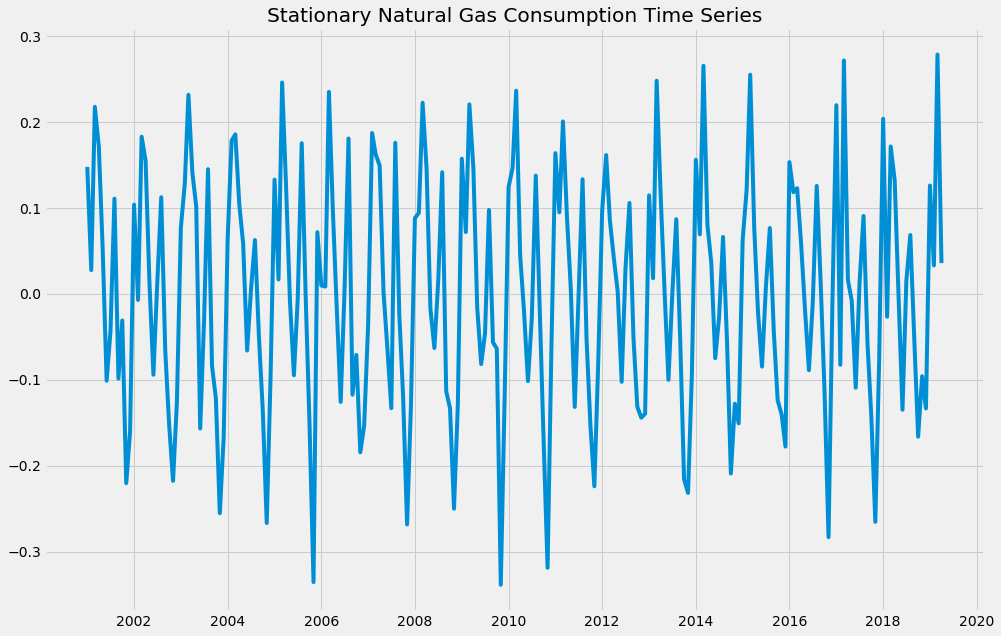

In [590]:
plt.figure(figsize=(15,10))
plt.plot(df.diff_1)
plt.title('Stationary Natural Gas Consumption Time Series')
plt.show()

In [591]:
df.dtypes

Cons_Mcf    float64
Prod_Mcf    float64
Price       float64
diff_1      float64
dtype: object

In [592]:
#make sure the differenced data is stationary
stationarity_test('Consumption', df.diff_1[1:])

Consumption :
ADF Statistic -4.868425
p-value: 0.000040
Consumption is stationary, hooray!



Text(0.5, 1.0, 'Energy Consumption ACF')

<Figure size 1440x1440 with 0 Axes>

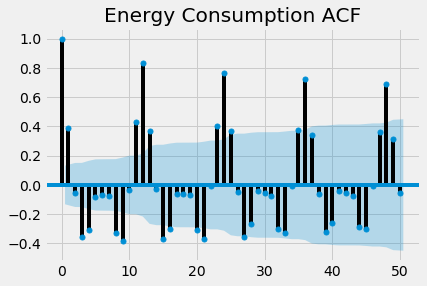

In [593]:
#ACF Difference data
plt.figure(figsize=(20,20))
plot_acf(df.diff_1[1:], lags=50)
plt.title("Energy Consumption ACF")


The ACF above shows seasonal data that reiterates a pattern every 12 months

Text(0.5, 1.0, 'Energy Consumption PACF')

<Figure size 1440x1440 with 0 Axes>

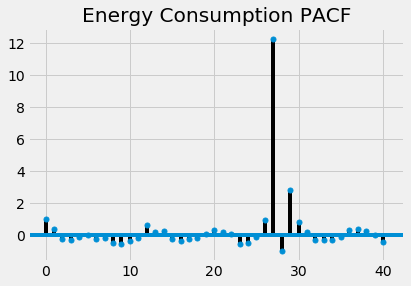

In [594]:
plt.figure(figsize=(20,20))
plot_pacf(df.diff_1[1:], lags=40)
plt.title("Energy Consumption PACF")

In [595]:
df.head(20)

,Cons_Mcf,Prod_Mcf,Price,diff_1
Date,,,,
2019-05-01,2106106.0,2785972.0,3.65,NaN
2019-04-01,2182752.0,2712573.0,4.02,0.035746
2019-03-01,2883397.0,2791525.0,4.33,0.278383
2019-02-01,2980360.0,2506257.0,4.65,0.033075
2019-01-01,3380597.0,2750413.0,5.04,0.126008
2018-12-01,2958554.0,2756095.0,5.46,-0.133352
2018-11-01,2687995.0,2656502.0,4.51,-0.095905
2018-10-01,2276313.0,2702488.0,4.04,-0.166239
2018-09-01,2158549.0,2590301.0,3.75,-0.053121


In [596]:
#Create training and testing data
# 2 year history for test and rest for train
train_90 = df.diff_1[24:]
test_90 = df.diff_1[1:24]
print('Consumption train:', len(train_90), 
      '\nConsumption test:', len(test_90), 
      '\nFraction of total data set:', len(test_90)/len(df.Cons_Mcf))

Consumption train: 197 
Consumption test: 23 
Fraction of total data set: 0.10407239819004525


# 6.  Model Building

# 6.1 ARIMA

In [597]:
# Function to generate predictions for a given arima order
def evaluate_arima(train, test, arima_order):
    # Populate history based on training set
    history = [x for x in train]
    
    # Create blank list of predictions to populate
    predictions = list()
    
    # Use rolling forward walk predictions.  Fit model using history,
    # adding each prediction to history to continue forecasting
    
    for i in range(len(test)):
        # Fit using history
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        
        # Get prediction
        y_pred = model_fit.forecast()[0]
        
        # Append prediction to prediction list to check accuracy 
        predictions.append(y_pred)
        
        # Append to history to continue to rolling forecast 
        history.append(y_pred)
    
    error = mean_squared_error(test, predictions)
    return error

# Function to determine best arima order combination based on lowest MSE
def arima_gridsearch(train, test, p_vals, d_vals, q_vals):
    
    best_score = float('inf') 
    best_config = None
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                arima_order = (p, d, q)
                try:
                    mse = evaluate_arima(train, test, arima_order)
                    if mse < best_score:
                        best_score, best_config = mse, arima_order
                    print('ARIMA config: {}; MSE:{}'.format(arima_order, mse))
                except: #(ValueError, np.linalg.LinAlgError): # ignore non converging errors
                    pass
    
    print('Best ARIMA config:', best_config)
    print('MSE:', best_score)

In [598]:
#arima_gridsearch(train_90, test_90, range(0, 6, 1), range(2), range(0, 11, 1))

In [599]:
order = 0,0,1
model_best = ARIMA(train_90, order=order)
model_fit = model_best.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 diff_1   No. Observations:                  197
Model:                     ARMA(0, 1)   Log Likelihood                 136.320
Method:                       css-mle   S.D. of innovations              0.121
Date:                Wed, 14 Aug 2019   AIC                           -266.640
Time:                        23:24:20   BIC                           -256.790
Sample:                    05-01-2017   HQIC                          -262.653
                         - 01-01-2001                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0022      0.012      0.176      0.861      -0.022       0.026
ma.L1.diff_1     0.4297      0.061      7.089      0.000       0.311       0.548
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.3274           +0.0000j            2.3274            0.5000
-----------------------------------------------------------------------------
"""

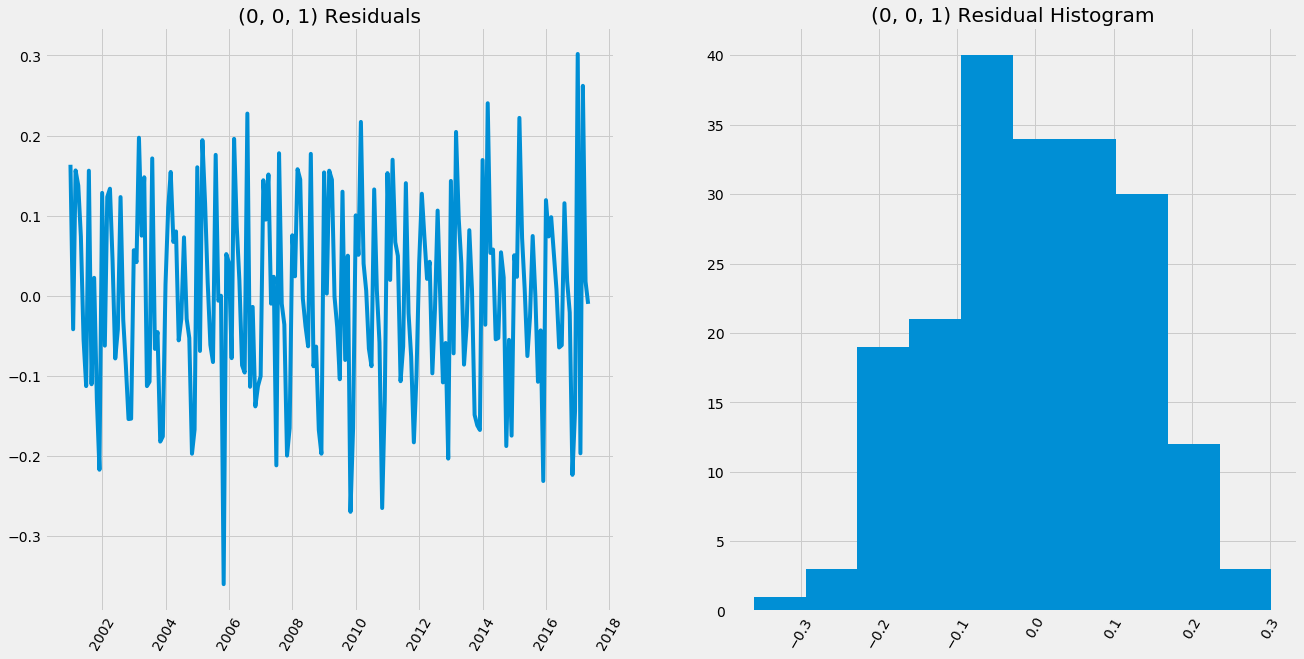

count    197.000000
mean      -0.000071
std        0.121381
min       -0.359942
25%       -0.082739
50%       -0.000261
75%        0.086160
max        0.301754
dtype: float64


In [600]:
residuals = model_fit.resid
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.xticks(rotation=60)
plt.title('{} Residuals'.format(order))
plt.plot(residuals)

plt.subplot(1,2,2)
plt.hist(residuals)
plt.title('{} Residual Histogram'.format(order))
plt.xticks(rotation=60)
plt.show()

print(residuals.describe())

The distribution of the residual errors is displayed. The results show that indeed there is a no bias in the prediction (mean close to 0)

predicted=0.072404, expected=0.035746
predicted=-0.013546, expected=0.278383
predicted=0.125323, expected=0.033075
predicted=-0.033467, expected=0.126008
predicted=0.067721, expected=-0.133352
predicted=-0.074482, expected=-0.095905
predicted=-0.005355, expected=-0.166239
predicted=-0.060650, expected=-0.053121
predicted=0.004745, expected=0.068404
predicted=0.027043, expected=0.015047
predicted=-0.002482, expected=-0.134881
predicted=-0.050363, expected=-0.001746
predicted=0.020485, expected=0.132274
predicted=0.046033, expected=0.171505
predicted=0.052492, expected=-0.026694
predicted=-0.028279, expected=0.203725
predicted=0.093509, expected=-0.076769
predicted=-0.060006, expected=-0.265342
predicted=-0.076655, expected=-0.143509
predicted=-0.024628, expected=-0.057792
predicted=-0.011777, expected=0.090603
predicted=0.041612, expected=0.013128
predicted=-0.009429, expected=-0.109201
Test 0,0,1 MSE: 0.017


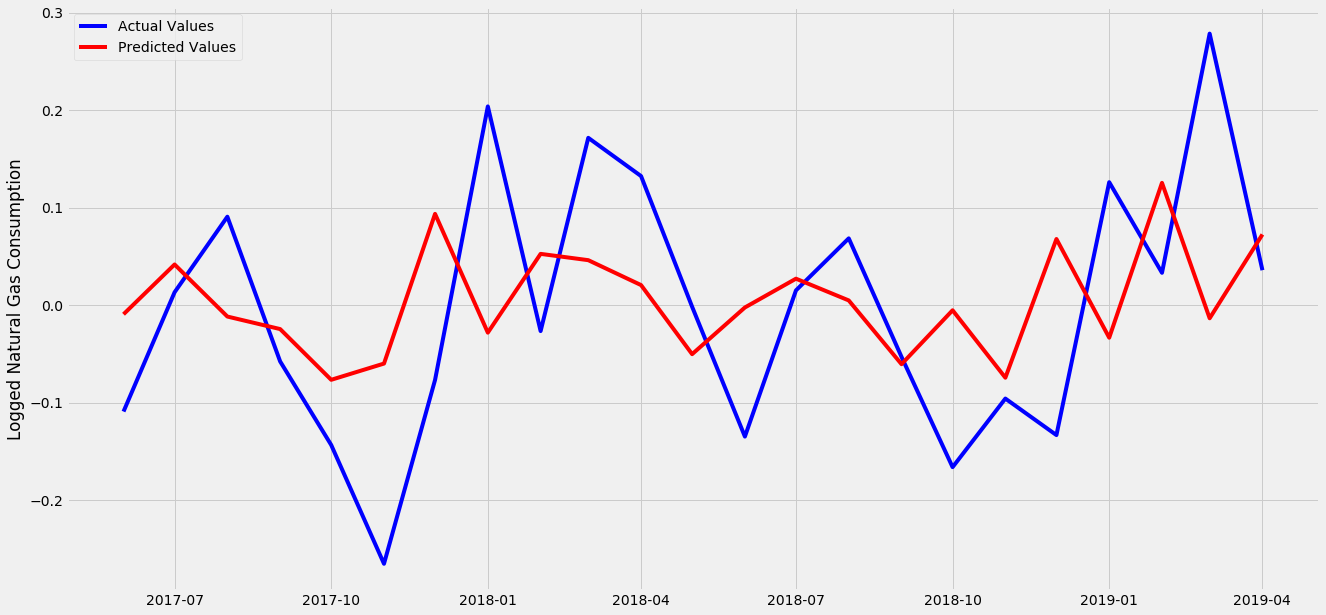

In [601]:
history = [x for x in train_90]
predictions = list()
for t in range(len(test_90)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_90[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_90, predictions)
print('Test 0,0,1 MSE: %.3f' % error)
# plot
def plot_arima(data, prediction):
    plt.figure(figsize = (20,10))
    plt.plot(data.index,data, color = 'blue', label="Actual Values")
    plt.plot(data.index,prediction, color='red', label='Predicted Values')
    plt.ylabel('Logged Natural Gas Consumption')
    plt.legend(loc='best')
plot_arima(test_90, predictions)

[-0.00942936  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605  0.00160605
  0.00160605  0.00160605  0.00160605  0.00160605  0

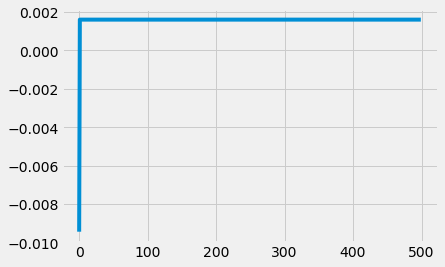

In [602]:
#try to create out-of-series forecasts
forecast = model_fit.forecast(steps=500)[0]
print(forecast)
pred = forecast.tolist()
plt.plot(pred)

Looks like for future forecasting, the model is just reverting straight back to the mean. Let's try another model.

# 6.2 SARIMAX

The next model is a seasonal ARIMA model with exogenous variables. For the first iteration we are going to use the data as is, without differencing, due to the fact that Seasonal ARIMA models include a type of stochastic trend (if the differencing order is at least 1) and seasonality, which means that they are perfectly capable of accounting for those.

In [603]:
#log the data
y = np.log(df['Cons_Mcf'])
# The 'MS' string groups the data in buckets by start of the month
y = y.resample('MS').mean()
y = y.fillna(y.bfill())

#y_train = y[1:197]
#y_test = y[197:]
tr_start,tr_end = '2003-01-01','2017-05-01'
te_start,te_end = '2017-06-01','2019-05-01'
tra = y[tr_start:tr_end].dropna()
tes = y[te_start:te_end].dropna()

In [604]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [605]:
#function to try to find best combination for SARIMAX values with NON-differenced data
def sarimax_config(data):
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(tra,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                results = mod.fit()

                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue

In [606]:
#try with non-differenced training data
sarimax_config(tra)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1410.057848299334
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1314.7160344093231
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-428.43313443469543
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-391.4435329247656
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-439.3292939637213
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-460.202506494418
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-393.12298717409385
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-388.7950924793354
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1173.1302230247352
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1133.5373036725869
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-453.42341684634334
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-427.07129179889364
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-435.7855245334674
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-412.0172901320668
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-425.9657092269746
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-423.24790042773964
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-197.1630202950495
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-281.261

Looks like the lowest AIC is config (1,0,1)(1,0,1,12). Let's run that one

In [607]:
order = (1,1,1)
seasonal_order = (1,0,1,12)
def sarimax_run(data):
    mod = sm.tsa.statespace.SARIMAX(data,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=True,
                                enforce_invertibility=True)

    sarimax_results = mod.fit()
    return sarimax_results
print(sarimax_run(tra).summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5382      0.069      7.830      0.000       0.403       0.673
ma.L1         -0.9756      0.021    -45.726      0.000      -1.017      -0.934
ar.S.L12       0.9947      0.004    268.969      0.000       0.987       1.002
ma.S.L12      -0.7404      0.082     -8.995      0.000      -0.902      -0.579
sigma2         0.0022      0.000     10.575      0.000       0.002       0.003


Each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model

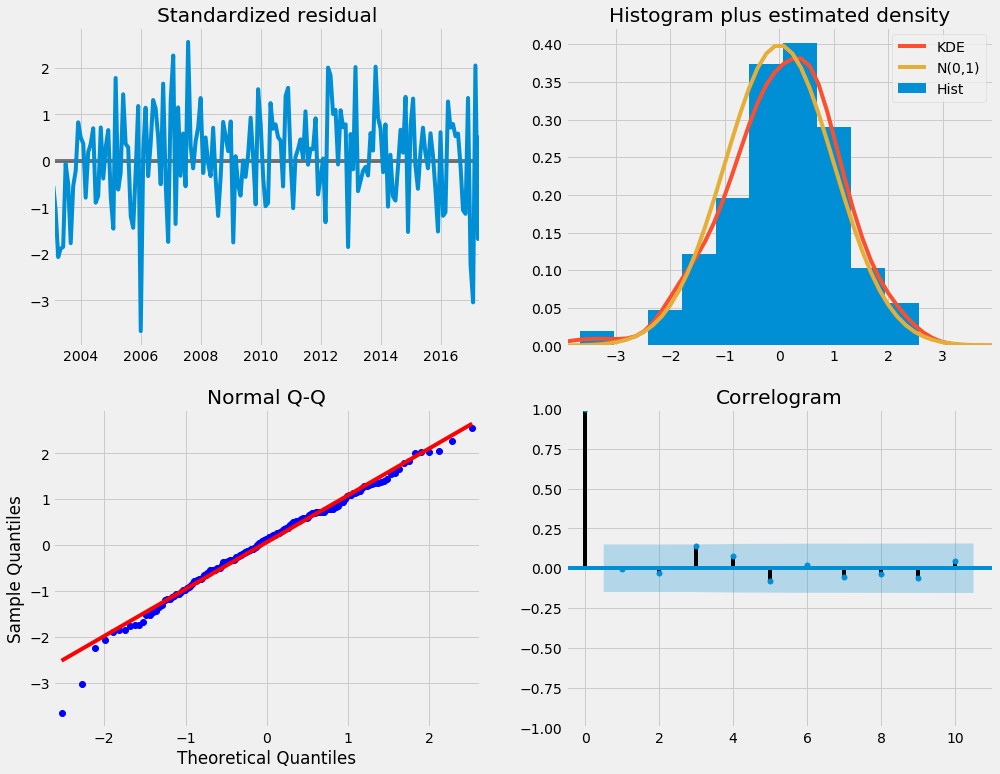

In [608]:
sarimax_run(tra).plot_diagnostics(figsize=(15, 12))
plt.show()

Now let's look at how it holds up against the test data

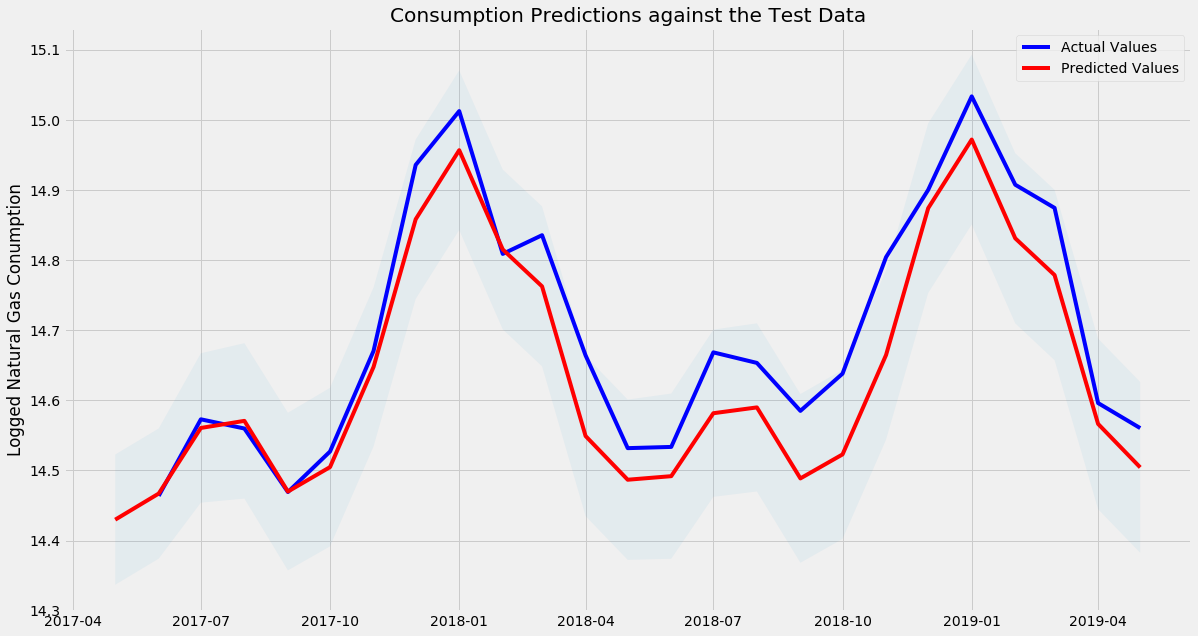

In [609]:
sarimax_results = sarimax_run(tra)
pred_res = sarimax_results.get_prediction(tr_end, te_end, full_results=True,alpha=0.05)
pred_means = pred_res.predicted_mean
# Specify your prediction intervals by alpha parameter. alpha=0.05 implies 95% CI
pred_cis = pred_res.conf_int(alpha=0.05)
    

def sarimax_plot_prediction(data, predicted_values,conf_ints):
    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(1,1,1)
    #Actual data
    ax.plot(data.astype('float64'), color="blue", label='Actual Values')
    # Means
    ax.plot(predicted_values, color="red", label='Predicted Values')
    ax.fill_between(predicted_values.index, conf_ints.iloc[:, 0], conf_ints.iloc[:, 1], alpha=0.05)
    ax.legend(loc='upper right')
    plt.ylabel('Logged Natural Gas Conumption')
    plt.title('Consumption Predictions against the Test Data')
    plt.draw()

sarimax_prediction(sarimax_results)
sarimax_plot_prediction(tes,pred_means,pred_cis)

In [610]:
# Compute the mean square error
def mse(predicted_means, test_data):
    mse = ((predicted_means - test_data) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
mse(pred_means,tes)

The Mean Squared Error of our forecasts is 0.0046


Text(0.5, 1.0, 'Natural Gas Consumption Ten Year Forecast')

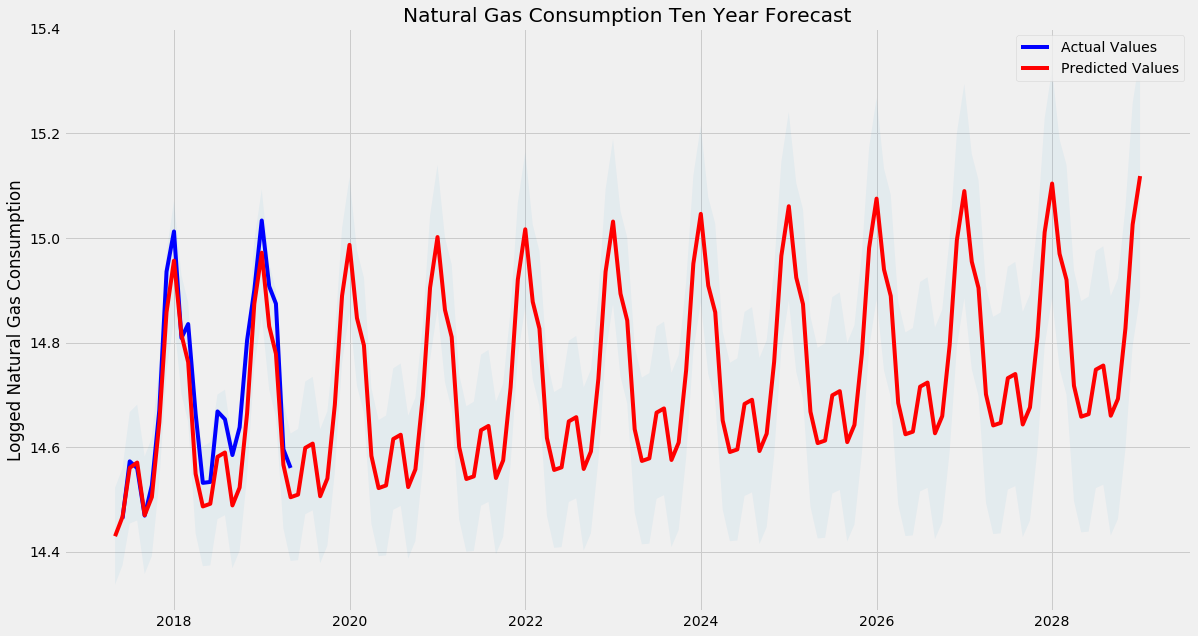

In [611]:
future = sarimax_results.get_prediction(tr_end, end = '2029-01-01', full_results=True,alpha=0.05)
future_means = future.predicted_mean
# Specify your prediction intervals by alpha parameter. alpha=0.05 implies 95% CI
future_cis = future.conf_int(alpha=0.05)

sarimax_plot_prediction(tes,future_means,future_cis)
plt.ylabel('Logged Natural Gas Consumption')
plt.title('Natural Gas Consumption Ten Year Forecast')

That's pretty good, but let's try again without hold-out groups

In [612]:
#try to find best combination for SARIMAX values with all the non-differenced data included
sarimax_config(y)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1410.057848299334
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1314.7160344093231
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-428.43313443469543
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-391.4435329247656
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-439.3292939637213
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-460.202506494418
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-393.12298717409385
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-388.7950924793354
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1173.1302230247352
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1133.5373036725869
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-453.42341684634334
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-427.07129179889364
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-435.7855245334674
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-412.0172901320668
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-425.9657092269746
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-423.24790042773964
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-197.1630202950495
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-281.261

In [613]:
order = (0,1,1)
seasonal_order = (1,0,1,12)
print(sarimax_run(y).summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4572      0.061     -7.553      0.000      -0.576      -0.339
ar.S.L12       0.9977      0.002    580.552      0.000       0.994       1.001
ma.S.L12      -0.7853      0.062    -12.654      0.000      -0.907      -0.664
sigma2         0.0024      0.000     10.699      0.000       0.002       0.003


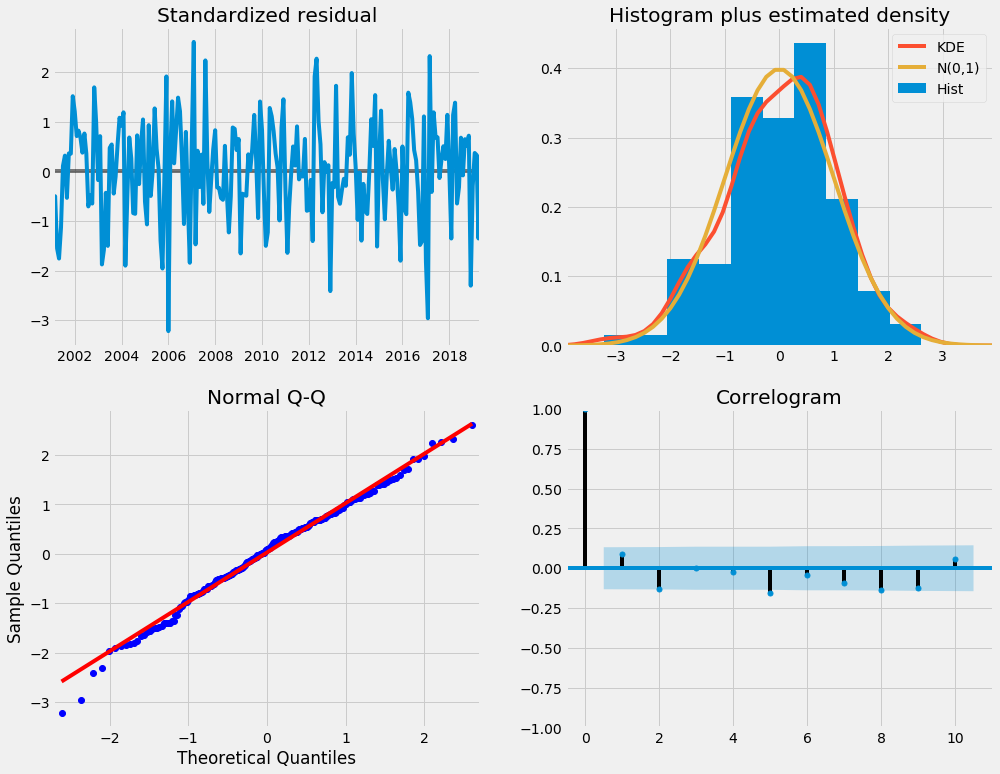

In [614]:
sarimax_run(y).plot_diagnostics(figsize=(15, 12))
plt.show()

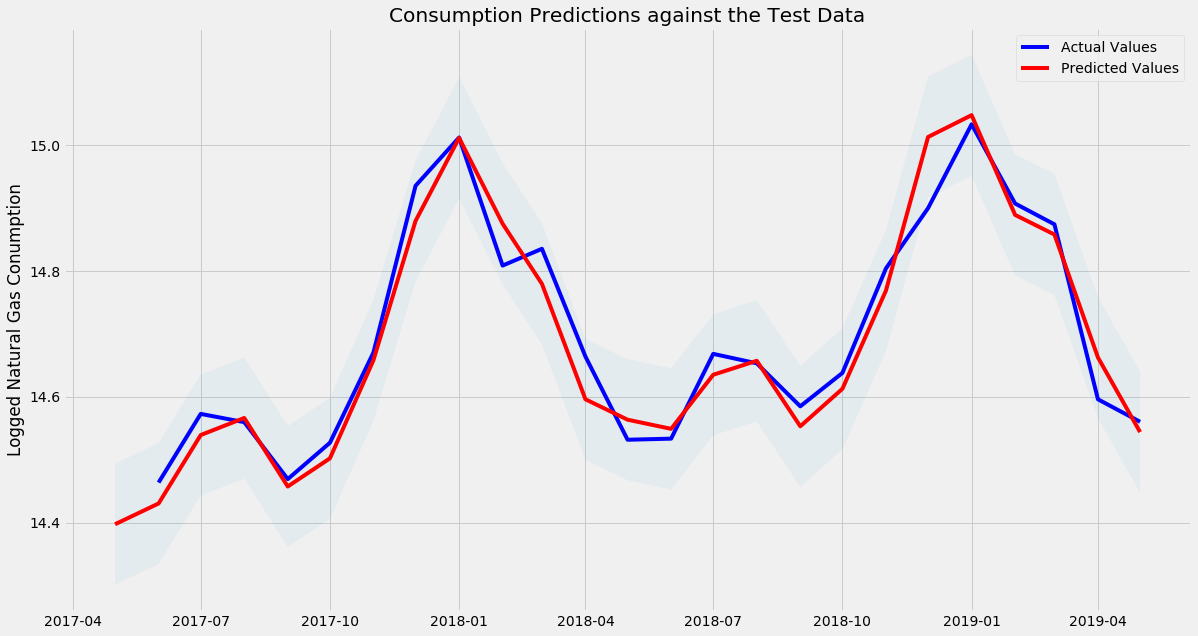

In [615]:
sarimax_results = sarimax_run(y)
pred_res = sarimax_results.get_prediction(tr_end, te_end, full_results=True,alpha=0.05)
pred_means = pred_res.predicted_mean
# Specify your prediction intervals by alpha parameter. alpha=0.05 implies 95% CI
pred_cis = pred_res.conf_int(alpha=0.05)

sarimax_prediction(sarimax_results)
sarimax_plot_prediction(tes,pred_means,pred_cis)

In [616]:
# Compute the mean square error
mse(pred_means,tes)

The Mean Squared Error of our forecasts is 0.0018


The MSE is better, but let's see if it forecasts

Text(0.5, 1.0, 'Natural Gas Consumption Ten Year Forecast')

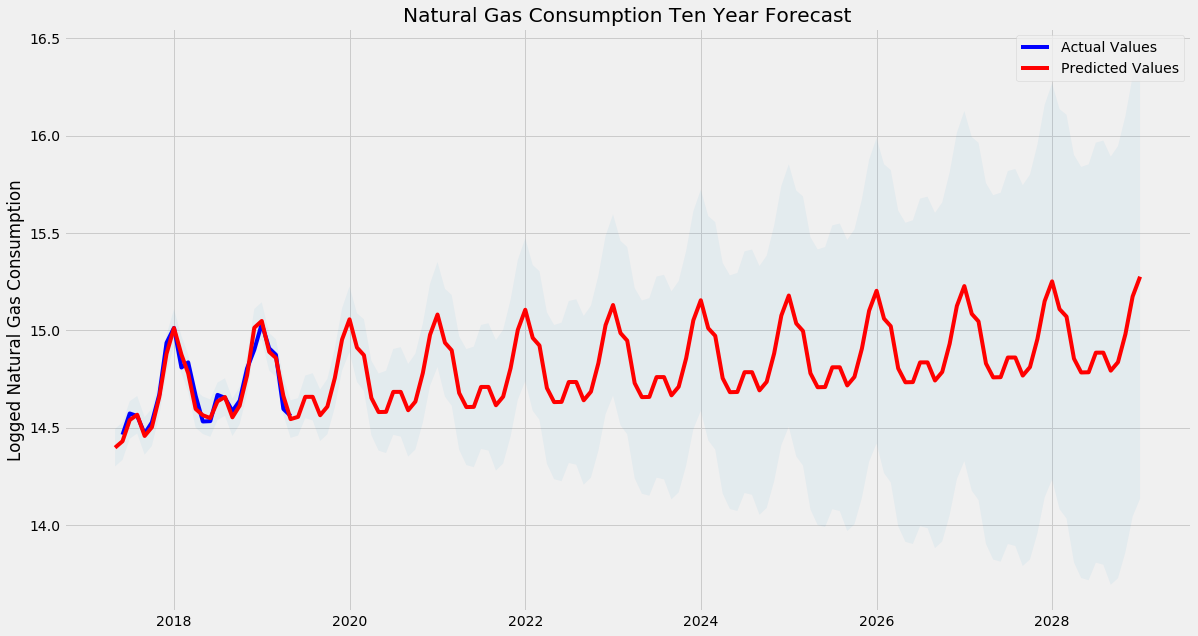

In [617]:
future = sarimax_results.get_prediction(tr_end, end = '2029-01-01', full_results=True,alpha=0.05)
future_means = future.predicted_mean
# Specify your prediction intervals by alpha parameter. alpha=0.05 implies 95% CI
future_cis = future.conf_int(alpha=0.05)

sarimax_plot_prediction(tes,future_means,future_cis)
plt.ylabel('Logged Natural Gas Consumption')
plt.title('Natural Gas Consumption Ten Year Forecast')


Not bad! Let's try differenced data with holdout groups!

In [618]:
#use differenced training data
df.diff_2 = df.diff_1.sort_index(ascending=True)
train_diff = df.diff_2[1:197]
test_diff = df.diff_2[197:]

sarimax_config(train_diff)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1410.057848299334
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1314.7160344093231
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-428.43313443469543
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-391.4435329247656
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-439.3292939637213
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-460.202506494418
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-393.12298717409385
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-388.7950924793354
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1173.1302230247352
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1133.5373036725869
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-453.42341684634334
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-427.07129179889364
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-435.7855245334674
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-412.0172901320668
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-425.9657092269746
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-423.24790042773964
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-197.1630202950495
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-281.261

In [619]:
order = (1,0,1)
seasonal_order = (1,1,1,12)
print(sarimax_run(train_diff).summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4631      0.081      5.714      0.000       0.304       0.622
ma.L1         -0.9418      0.040    -23.634      0.000      -1.020      -0.864
ar.S.L12       0.0955      0.111      0.857      0.391      -0.123       0.314
ma.S.L12      -0.8487      0.098     -8.687      0.000      -1.040      -0.657
sigma2         0.0022      0.000     10.171      0.000       0.002       0.003


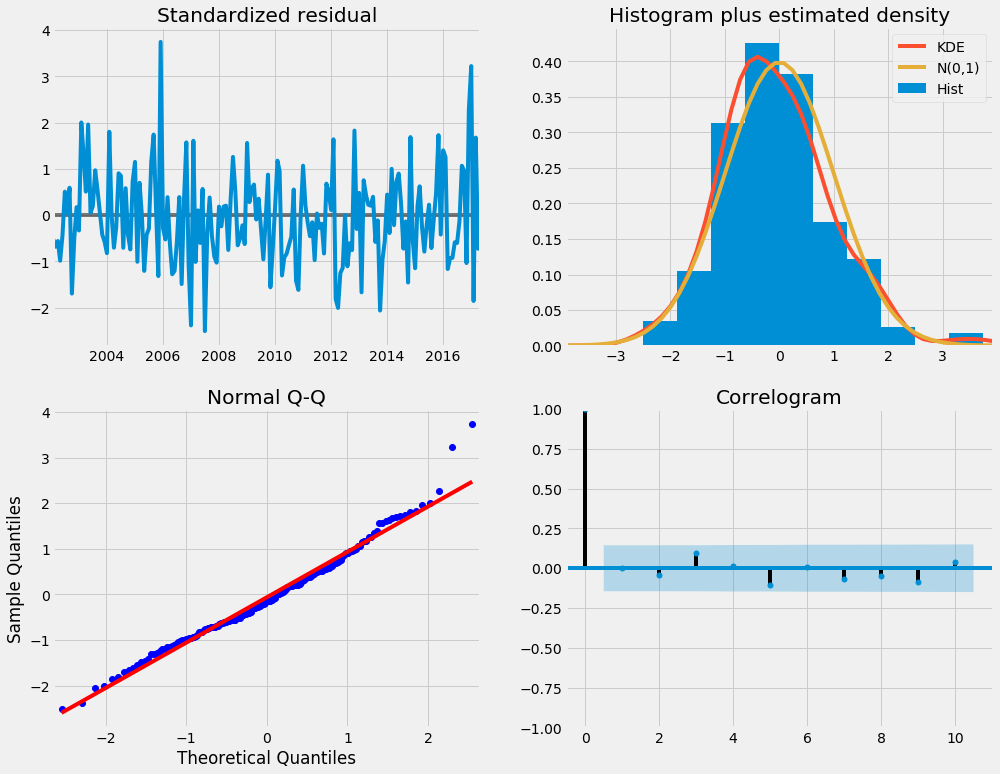

In [620]:
sarimax_diff_results = sarimax_run(train_diff)
sarimax_diff_results.plot_diagnostics(figsize=(15, 12))
plt.show()

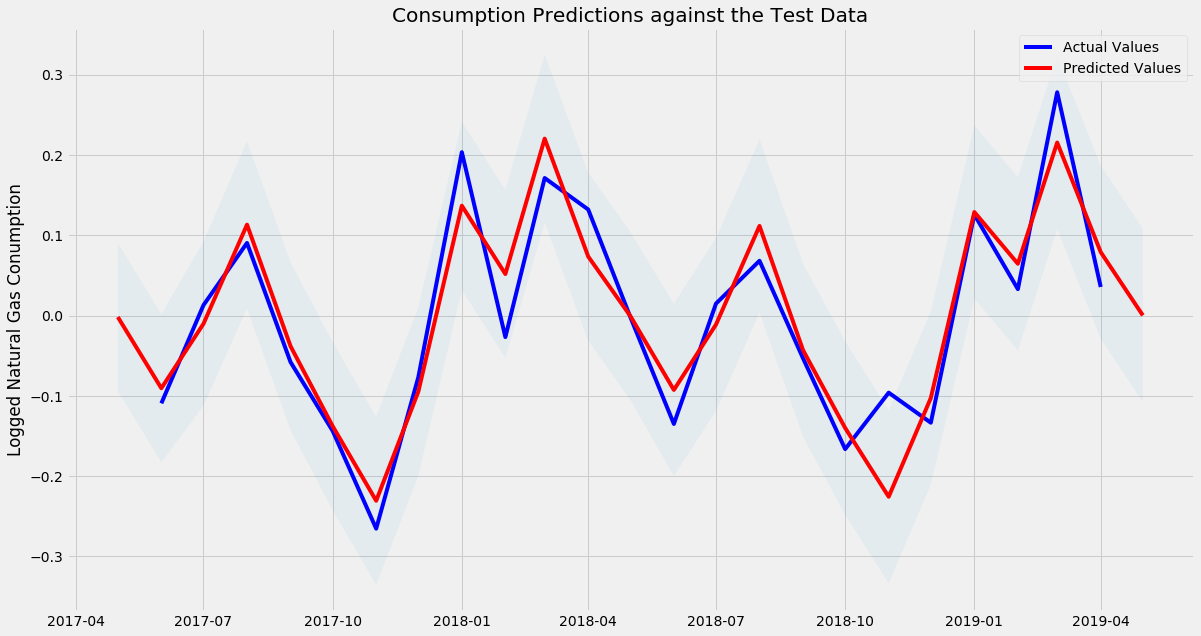

In [621]:
pred_res = sarimax_diff_results.get_prediction(tr_end, te_end, full_results=True,alpha=0.05)
pred_means = pred_res.predicted_mean
# Specify your prediction intervals by alpha parameter. alpha=0.05 implies 95% CI
pred_cis = pred_res.conf_int(alpha=0.05)
sarimax_plot_prediction(test_diff,pred_means,pred_cis)

In [622]:
mse(pred_means,test_diff)

The Mean Squared Error of our forecasts is 0.0022


Better! Now let's see if it forecasts

Text(0.5, 1.0, 'Natural Gas Consumption Ten Year Forecast, Stationary Data')

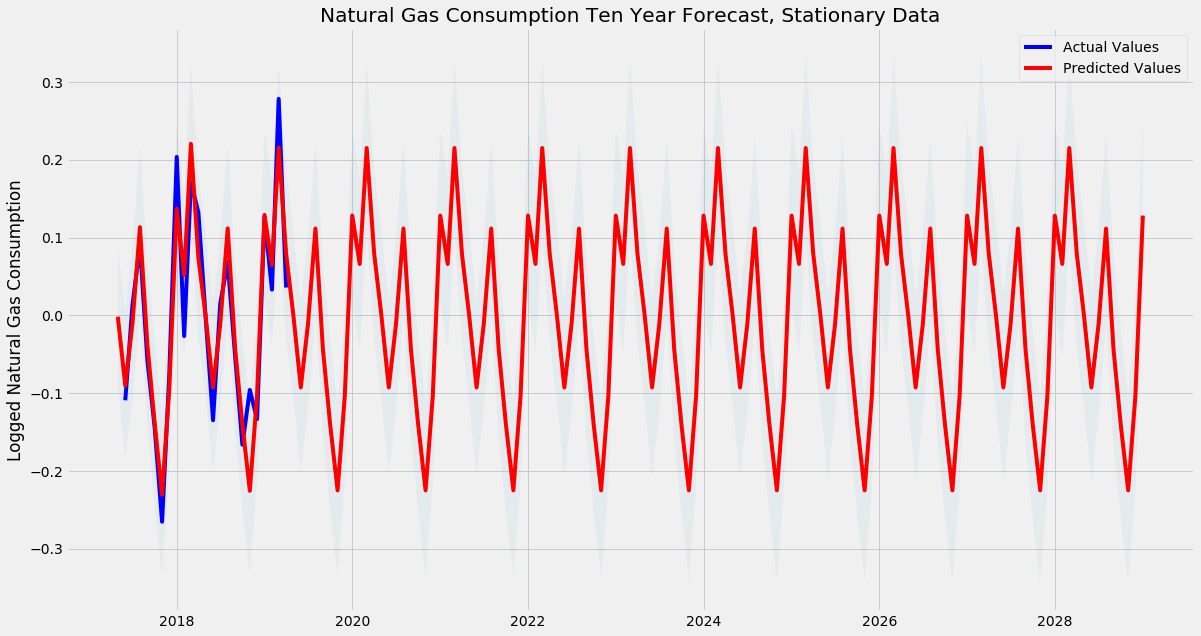

In [623]:
pred_res = sarimax_diff_results.get_prediction(tr_end, end = '2029-01-01', full_results=True,alpha=0.05)
pred_means = pred_res.predicted_mean
# Specify your prediction intervals by alpha parameter. alpha=0.05 implies 95% CI
pred_cis = pred_res.conf_int(alpha=0.05)

sarimax_plot_prediction(test_diff,pred_means,pred_cis)
plt.ylabel('Logged Natural Gas Consumption')
plt.title('Natural Gas Consumption Ten Year Forecast, Stationary Data')


In [624]:
Hooray! 

SyntaxError: invalid syntax (<ipython-input-624-859424dee86a>, line 1)

# 6.3 FB Prophet

In [ ]:
from fbprophet import Prophet
# Prophet requires specific input format.  
# Columns names must be lowercase, date as 'ds', data as 'y'
prophet = df['Cons_Mcf'].dropna().reset_index()
prophet = prophet.rename(columns={'Date': 'ds', 'Cons_Mcf': 'y'})
prophet.head()

In [ ]:
proph_model = Prophet(daily_seasonality=False)
proph_model.fit(prophet)
proph_future = proph_model.make_future_dataframe(periods=365)
proph_forecast = proph_model.predict(proph_future)

In [ ]:
# Plot 
proph_model.plot(proph_forecast)
plt.title('Natural Gas Consumption\n1-Yr Forecast\nNo Hold Out Data, Default Parameters')
plt.ylabel('Gas Consumed')
plt.legend()
plt.show()

In [ ]:
# Plot zoomed in to 2018
proph_model.plot(proph_forecast)
plt.title('Natural Gas Consumption\n1-Yr Forecast\nNo Hold Out Data, Default Parameters')
plt.ylabel('Gas Consumed')
plt.xlim([dt.date(2018, 1, 1), dt.date(2020, 5, 1)])
plt.legend()
plt.show()

## Summary/Conclusions

For this data, the standard ARIMA models were not sufficient to support forecasting future natural gas consumption. Once I added in exogenous seasonality variables, the model began to function. The best model was the model that had non-differenced data and a configuration of (1,1,1) and a seasonal configuration of (1,0,1,12). This model had the lowest standard error and the largest confidence interval moving forward. 